In [1]:
import pandas as pd
import numpy as np

import plotnine as p9

In [14]:
searches_iter = pd.read_csv(
           "/searches.csv.bz2", 
            chunksize=10000,
            usecols=["Date", 'Destination'],
            parse_dates=["Date"],
            delimiter="^")

In [15]:
searches_per_date = pd.DataFrame({'Date': [], 'Destination': [], 'Count': []})
searches_per_date

,Date,Destination,Count


In [16]:
airports = ["MAD", "BCN", "AGP"]
count = 0

for searches_chunk in searches_iter:
    grp = (
        searches_chunk
        .dropna()
        .query('Destination in @airports')
        .groupby(['Date', 'Destination'], as_index=False)
        .agg(Count = ('Date','count'))
    )

    searches_per_date = searches_per_date.append(grp, ignore_index=True)

In [17]:
searches_per_date.to_csv('searches_per_date.csv')

In [43]:
searches_per_month = (
    searches_per_date
    .assign(
        Date=searches_per_date['Date'].astype('datetime64'),
        Month=searches_per_date['Date'].dt.month,
        Count=searches_per_date['Count'].astype('int')
    )
    .groupby(['Month', 'Destination'], as_index=False)
    .agg(Searches = ('Count', np.sum))
)

In [39]:
searches_per_month.head()

,Date,Destination,Count,Month
0,2013-01-01,AGP,7,1
1,2013-01-01,BCN,26,1
2,2013-01-01,MAD,11,1
3,2013-01-02,AGP,4,1
4,2013-01-02,BCN,9,1


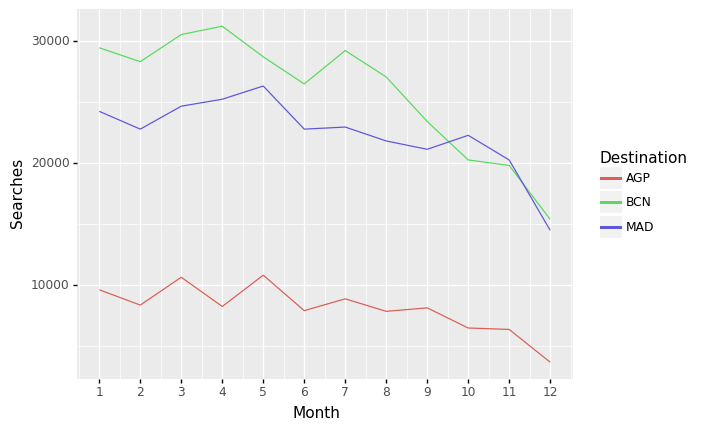

<ggplot: (124246806797)>

In [48]:
(
    p9.ggplot(searches_per_month, p9.aes(x='Month', y='Searches', color='Destination'))
    + p9.geom_line()
    + p9.scale_x_continuous(breaks=range(1,13))
)